In [9]:
%matplotlib widget
from amftrack.pipeline.functions.post_processing.area_hulls import *
from amftrack.util.dbx import upload_folder
from amftrack.pipeline.launching.run_super import run_parallel, run_launcher
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)
from amftrack.util.geometry import (
    distance_point_pixel_line,
    get_closest_line_opt,
    get_closest_lines,
    format_region,
    intersect_rectangle,
    get_overlap,
    get_bounding_box,
    expand_bounding_box,
    is_in_bounding_box,
    centered_bounding_box,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    plot_hulls_skelet,
    plot_full,
    reconstruct_image_from_general,
)
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from time import time_ns
from amftrack.util.dbx import upload_folders, load_dbx, download, get_dropbox_folders
from datetime import datetime
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
)

In [3]:
directory_targ = directory_project

update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/3431 [00:00<?, ?it/s]

In [7]:
folders

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,unique_id,datetime


In [32]:
folders = all_folders.loc[all_folders["Plate"] == "1048"]
folders = folders.sort_values("datetime")
folders = folders.iloc[:10]
exp = Experiment(directory_targ)
exp.load(folders)
exp.dates.sort()

2022-05-06 23:50:00
2022-05-07 01:50:00
2022-05-07 03:50:00
2022-05-07 05:50:00
2022-05-07 07:50:00
2022-05-07 09:50:00
2022-05-07 11:50:00
2022-05-07 13:50:00
2022-05-07 15:50:00
2022-05-07 17:50:00


In [33]:
from amftrack.pipeline.functions.image_processing.hyphae_id_surf import *

new_graph_list, new_poss_list = reduce_labels(exp.nx_graph, exp.positions)
exp.nx_graph, exp.positions = new_graph_list, new_poss_list
labels = {node for g in exp.nx_graph for node in g}
exp.nodes = []
for label in labels:
    exp.nodes.append(Node(label, exp))

In [40]:
ends = [node for node in exp.nodes if node.degree(node.ts()[0]) == 1]

In [41]:
len(exp.nodes)

2045

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_util.py:421: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figsize=(12, 8)


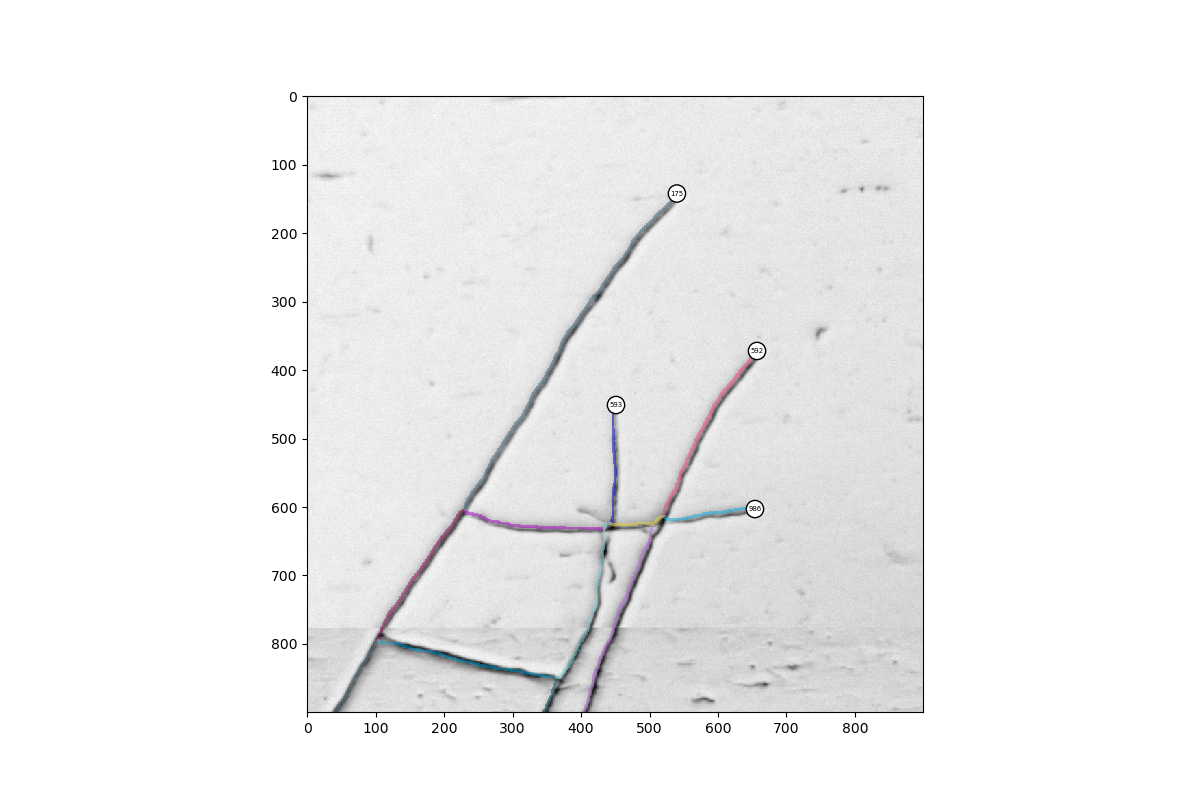

In [48]:
t = 5
exp.load_tile_information(t)
to_choose = [end for end in ends if end.is_in(t)]
node = choice(to_choose)
# node = hypha.end
pos = node.pos(t)
window = 600

region = centered_bounding_box(pos, size=int(1.5 * window))

plot_full(
    exp,
    t,
    region=region,
    downsizing=1,
    nodes=[
        node
        for node in ends
        if node.is_in(t) and np.linalg.norm(node.pos(t) - pos) <= window
    ],
    edges=get_all_edges(exp, t),
    # edges = [],
    dilation=4,
    prettify=False,
)

In [36]:
hyphaes, problems = get_hyphae(exp, lim_considered=2)

0.0
0.8438818565400844
Detected problems during hyphae detection, 4 hyphaes have inconsistent root over time


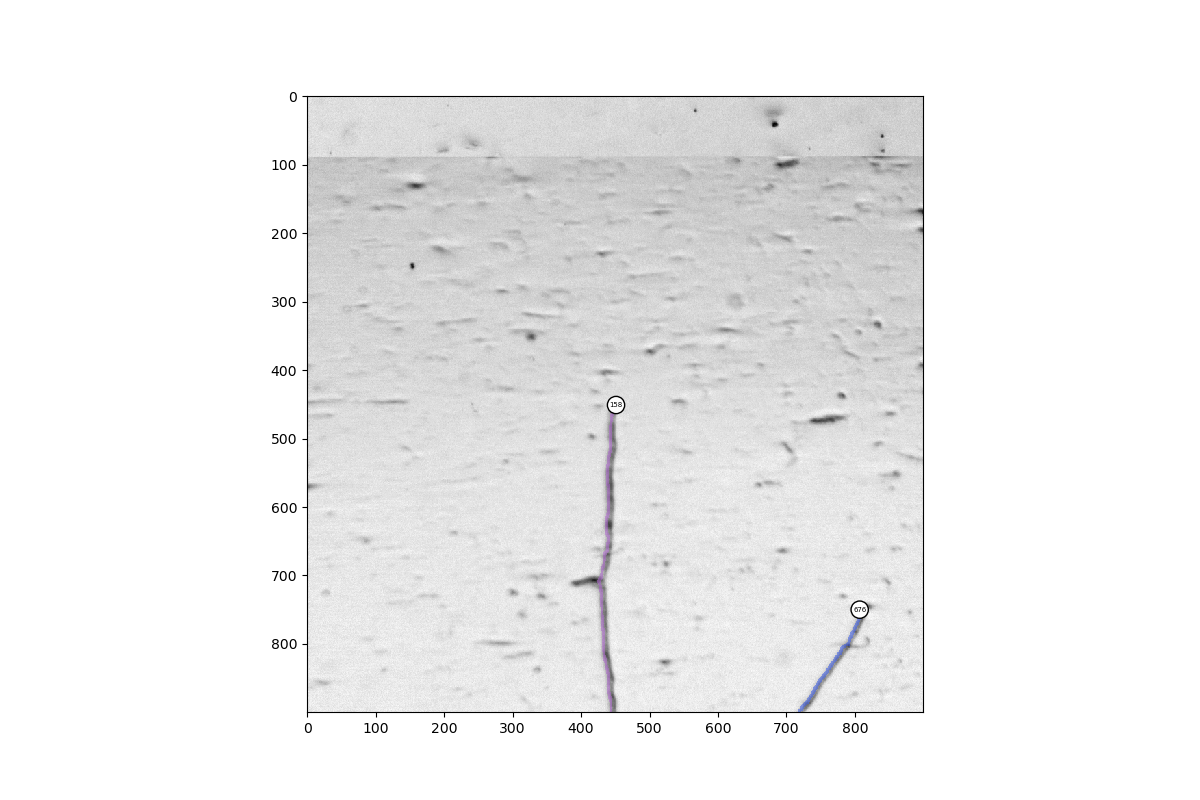

In [37]:
plot_full(
    exp,
    t,
    region=region,
    downsizing=1,
    nodes=[
        node
        for node in [hypha.end for hypha in hyphaes]
        if node.is_in(t) and np.linalg.norm(node.pos(t) - pos) <= window
    ],
    edges=get_all_edges(exp, t),
    # edges = [],
    dilation=4,
    prettify=False,
)

In [38]:
resolve_anastomosis_crossing_by_root(exp)

0.0
0.6153846153846154
Detected problems during hyphae detection, 4 hyphaes have inconsistent root over time
getting anastomosing 321
relabeling
60
0
0
0
1
6
0
1
0
0
4
2
0
1
7
1
4
1
1
6
2
8
3
2
3
6
5
4
5
5
4
5
8
6
8
8
7
8
7
8
8
7
8
8
6
8
6
6
8
6
7
6
7
8
7
7
7
8
8
8
8
getting hyphae again
0.0
0.6369426751592356
Detected problems during hyphae detection, 4 hyphaes have inconsistent root over time


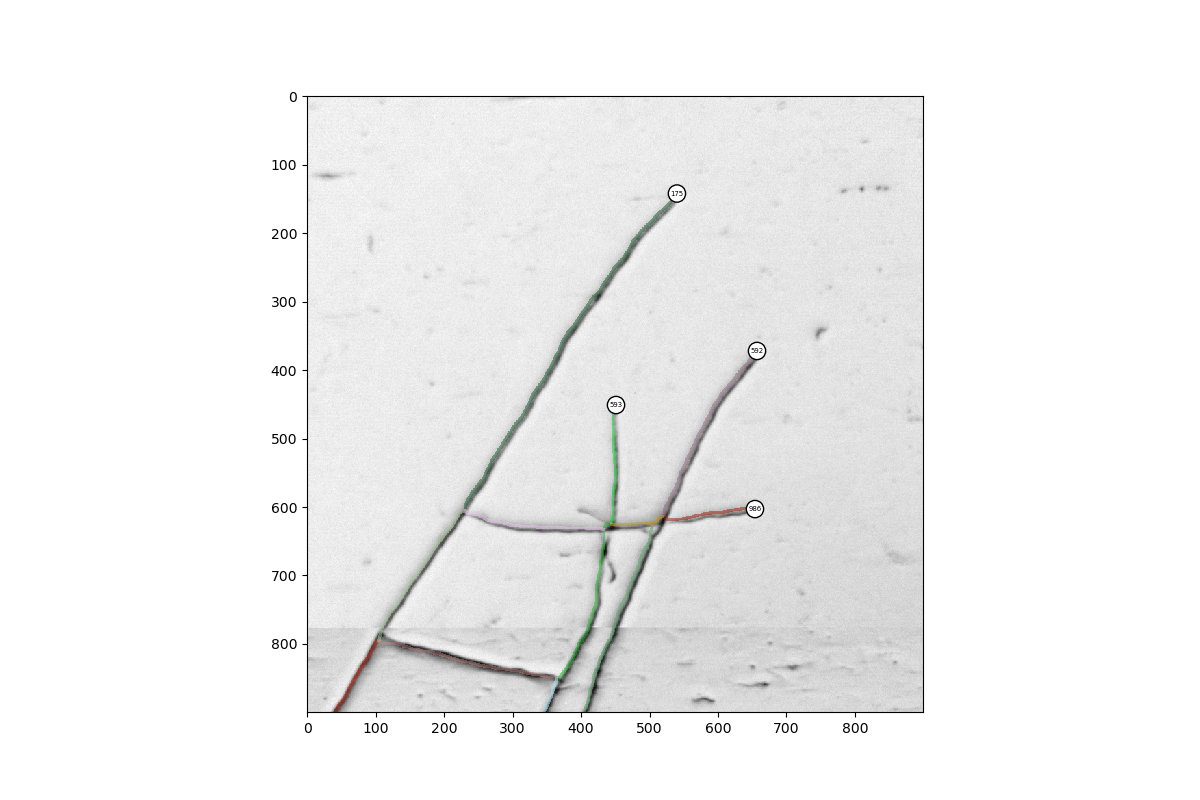

In [49]:
plot_full(
    exp,
    t,
    region=region,
    downsizing=1,
    nodes=[
        node
        for node in [hypha.end for hypha in exp.hyphaes]
        if node.is_in(t) and np.linalg.norm(node.pos(t) - pos) <= window
    ],
    edges=get_all_edges(exp, t),
    # edges = [],
    dilation=4,
    prettify=False,
)

In [52]:
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    run_launcher,
    run_parallel_all_time,
)

folders = all_folders.loc[all_folders["Plate"] == "1048"]
args = [directory_targ]
num_parallel = 32
time = "24:00:00"
limit = 100
version = 1
suffix = "_labeled"
lim_considered = 1
args = [directory_targ, limit, version, suffix, lim_considered]
run_parallel_all_time(
    "hyphae_extraction.py",
    args,
    folders,
    num_parallel,
    time,
    "hyphae",
    cpus=32,
    node="fat",
)

Submitted batch job 1559909


sbatch: Single node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: You will be charged for 0.25 node. A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 4 jobs.
